In [1]:
!pip install -q torchsummary

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.model_selection import train_test_split
from torchsummary import summary
from sklearn.metrics import classification_report
from torch.optim.lr_scheduler import OneCycleLR
import time

In [2]:
!git clone https://github.com/Indoxer/LKAN.git

Cloning into 'LKAN'...
remote: Enumerating objects: 799, done.
remote: Counting objects: 100% (293/293), done.
remote: Compressing objects: 100% (185/185), done.
remote: Total 799 (delta 180), reused 215 (delta 106), pack-reused 506
Receiving objects: 100% (799/799), 3.38 MiB | 20.26 MiB/s, done.
Resolving deltas: 100% (453/453), done.


In [3]:
%cd LKAN

/kaggle/working/LKAN


In [4]:
!ls /kaggle/working

LKAN


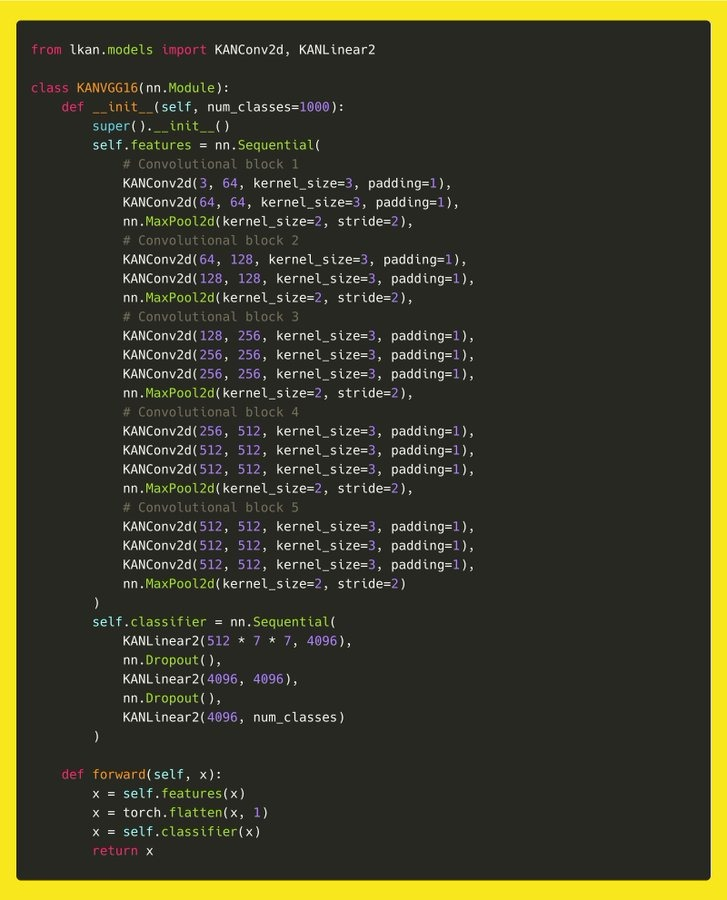

In [5]:
import os
import sys
sys.path.append(os.path.abspath('LKAN'))

from lkan.models.layers.kanconv2d import KANConv2d
from lkan.models.layers.kan_linear import KANLinear

class LKANVGG16(nn.Module):
    def __init__ (self, num_classes=10):
        super(LKANVGG16, self).__init__()
        self.features = nn.Sequential(
            # Conv block 1
            KANConv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            KANConv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            
            # Conv blok 2
            KANConv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            KANConv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            
            # Conv blok 3
            KANConv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            KANConv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            KANConv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(256),
            
            # Conv blok 4
            KANConv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            KANConv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            KANConv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(512),
            
            # Conv blok 5
            KANConv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            KANConv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            KANConv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(512),
        )
        self.classifier = nn.Sequential(
            KANLinear(512 * 1 * 1, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            KANLinear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            KANLinear(4096, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [6]:
"""
# KANLinear class definition as provided
class KANLinear(nn.Module):
    def __init__(self, in_features, out_features, grid_size=5, spline_order=3, scale_noise=0.1, scale_base=1.0, scale_spline=1.0, enable_standalone_scale_spline=True, base_activation=nn.SiLU, grid_eps=0.02, grid_range=[-1, 1]):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = ((torch.arange(-spline_order, grid_size + spline_order + 1) * h + grid_range[0]).expand(in_features, -1).contiguous())
        self.register_buffer("grid", grid)

        self.base_weight = nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = nn.Parameter(torch.Tensor(out_features, in_features, grid_size + spline_order))
        if enable_standalone_scale_spline:
            self.spline_scaler = nn.Parameter(torch.Tensor(out_features, in_features))

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = ((torch.rand(self.grid_size + 1, self.in_features, self.out_features) - 1 / 2) * self.scale_noise / self.grid_size)
            self.spline_weight.data.copy_((self.scale_spline if not self.enable_standalone_scale_spline else 1.0) * self.curve2coeff(self.grid.T[self.spline_order : -self.spline_order], noise))
            if self.enable_standalone_scale_spline:
                nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features
        grid = self.grid
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = ((x - grid[:, : -(k + 1)]) / (grid[:, k:-1] - grid[:, : -(k + 1)]) * bases[:, :, :-1]) + ((grid[:, k + 1 :] - x) / (grid[:, k + 1 :] - grid[:, 1:(-k)]) * bases[:, :, 1:])
        assert bases.size() == (x.size(0), self.in_features, self.grid_size + self.spline_order)
        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)
        A = self.b_splines(x).transpose(0, 1)
        B = y.transpose(0, 1)
        solution = torch.linalg.lstsq(A, B).solution
        result = solution.permute(2, 0, 1)
        assert result.size() == (self.out_features, self.in_features, self.grid_size + self.spline_order)
        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (self.spline_scaler.unsqueeze(-1) if self.enable_standalone_scale_spline else 1.0)

    def forward(self, x: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features
        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(self.b_splines(x).view(x.size(0), -1), self.scaled_spline_weight.view(self.out_features, -1))
        return base_output + spline_output

    @torch.no_grad()
    def update_grid(self, x: torch.Tensor, margin=0.01):
        assert x.dim() == 2 and x.size(1) == self.in_features
        batch = x.size(0)
        splines = self.b_splines(x).permute(1, 0, 2)
        orig_coeff = self.scaled_spline_weight.permute(1, 2, 0)
        unreduced_spline_output = torch.bmm(splines, orig_coeff).permute(1, 0, 2)
        x_sorted = torch.sort(x, dim=0)[0]
        grid_adaptive = x_sorted[torch.linspace(0, batch - 1, self.grid_size + 1, dtype=torch.int64, device=x.device)]
        uniform_step = (x_sorted[-1] - x_sorted[0] + 2 * margin) / self.grid_size
        grid_uniform = (torch.arange(self.grid_size + 1, dtype=torch.float32, device=x.device).unsqueeze(1) * uniform_step + x_sorted[0] - margin)
        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        grid = torch.cat([grid[:1] - uniform_step * torch.arange(self.spline_order, 0, -1, device=x.device).unsqueeze(1), grid, grid[-1:] + uniform_step * torch.arange(1, self.spline_order + 1, device=x.device).unsqueeze(1)], dim=0)
        self.grid.copy_(grid.T)
        self.spline_weight.data.copy_(self.curve2coeff(x, unreduced_spline_output))

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        l1_fake = self.spline_weight.abs().mean(-1)
        regularization_loss_activation = l1_fake.sum()
        p = l1_fake / regularization_loss_activation
        regularization_loss_entropy = -torch.sum(p * p.log())
        return regularize_activation * regularization_loss_activation + regularize_entropy * regularization_loss_entropy

"""

'\n# KANLinear class definition as provided\nclass KANLinear(nn.Module):\n    def __init__(self, in_features, out_features, grid_size=5, spline_order=3, scale_noise=0.1, scale_base=1.0, scale_spline=1.0, enable_standalone_scale_spline=True, base_activation=nn.SiLU, grid_eps=0.02, grid_range=[-1, 1]):\n        super(KANLinear, self).__init__()\n        self.in_features = in_features\n        self.out_features = out_features\n        self.grid_size = grid_size\n        self.spline_order = spline_order\n\n        h = (grid_range[1] - grid_range[0]) / grid_size\n        grid = ((torch.arange(-spline_order, grid_size + spline_order + 1) * h + grid_range[0]).expand(in_features, -1).contiguous())\n        self.register_buffer("grid", grid)\n\n        self.base_weight = nn.Parameter(torch.Tensor(out_features, in_features))\n        self.spline_weight = nn.Parameter(torch.Tensor(out_features, in_features, grid_size + spline_order))\n        if enable_standalone_scale_spline:\n            self.s

## Kode versi terbaru ini ditambahkan batch_normalisasi pada setiap akhir layer conv

1. Stabilisasi Distribusi Aktivasi:

Batch Normalization menstabilkan distribusi aktivasi jaringan dengan menormalkan output dari setiap layer berdasarkan mini-batch.
Ini membantu mengurangi masalah "vanishing gradients" (gradien menghilang) dan "exploding gradients" (gradien meledak), yang sering menjadi kendala dalam pelatihan jaringan yang dalam.

2. Akselerasi Konvergensi:

Dengan menormalkan input di setiap lapisan, model dapat menggunakan tingkat pembelajaran yang lebih tinggi tanpa takut terjebak dalam lokal minima atau divergen.
Hal ini mempercepat proses pelatihan karena model lebih cepat menemukan optimal point.

3. Regularisasi Implisit:

Batch Normalization menambahkan sedikit noise pada setiap mini-batch selama pelatihan, yang bertindak sebagai regularizer dan membantu mencegah overfitting.
Ini membuat model lebih generalizable ke data yang belum pernah dilihat sebelumnya.

4. Mengurangi Ketergantungan pada Inisialisasi Parameter:

Model menjadi lebih robust terhadap inisialisasi parameter yang buruk karena Batch Normalization mengontrol skala aktivasi.
Ini memungkinkan penggunaan berbagai skema inisialisasi tanpa kehilangan performa.

5. Mengurangi Sensitivitas terhadap Skala Input:

Dengan menormalkan data dalam mini-batch, Batch Normalization mengurangi sensitivitas model terhadap skala dan distribusi input awal.
Ini membantu dalam situasi di mana data memiliki berbagai macam skala dan distribusi.

In [7]:
"""
class KANVGG16(nn.Module):
    def __init__(self, num_classes=10):  # CIFAR100 has 10 classes
        super(KANVGG16, self).__init__()
        self.features = nn.Sequential(
            # Convolutional block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(64),

            # Convolutional block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(128),

            # Convolutional block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(256),

            # Convolutional block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(512),
            # Convolutional block 5
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(512),

        )
        self.classifier = nn.Sequential(
            KANLinear(512 * 1 * 1, 4096),  # Adjusted for CIFAR100 image size
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            KANLinear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            KANLinear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
"""

'\nclass KANVGG16(nn.Module):\n    def __init__(self, num_classes=10):  # CIFAR100 has 10 classes\n        super(KANVGG16, self).__init__()\n        self.features = nn.Sequential(\n            # Convolutional block 1\n            nn.Conv2d(3, 64, kernel_size=3, padding=1),\n            nn.ReLU(inplace=True),\n            nn.Conv2d(64, 64, kernel_size=3, padding=1),\n            nn.ReLU(inplace=True),\n            nn.MaxPool2d(kernel_size=2, stride=2),\n            nn.BatchNorm2d(64),\n\n            # Convolutional block 2\n            nn.Conv2d(64, 128, kernel_size=3, padding=1),\n            nn.ReLU(inplace=True),\n            nn.Conv2d(128, 128, kernel_size=3, padding=1),\n            nn.ReLU(inplace=True),\n            nn.MaxPool2d(kernel_size=2, stride=2),\n            nn.BatchNorm2d(128),\n\n            # Convolutional block 3\n            nn.Conv2d(128, 256, kernel_size=3, padding=1),\n            nn.ReLU(inplace=True),\n            nn.Conv2d(256, 256, kernel_size=3, padding=1),\

In [8]:
# Input jumlah epoch
epochs = 5
batch_size = 128

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize model
model = LKANVGG16(num_classes=10).to(device)
print(model)
summary(model, input_size=(3, 32, 32))

# DataParallel if more than one GPU is available
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

# Function to print model parameter details
def print_parameter_details(model):
    for name, param in model.named_parameters():
        print(f"{name}: {param.size()} {'requires_grad' if param.requires_grad else 'frozen'}")

print_parameter_details(model)

# Define transformations for training and validation data
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize(32),
    transforms.CenterCrop(32),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_val)

# Split training set into train and validation sets
train_indices, val_indices = train_test_split(list(range(len(trainset))), test_size=0.2, stratify=trainset.targets)
train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)

# Define DataLoaders
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=train_sampler, num_workers=2)
val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=val_sampler, num_workers=2)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001, steps_per_epoch=len(train_loader), epochs=epochs)

# Training function
def train(model, train_loader, criterion, optimizer, device, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        if batch_idx % 10 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(inputs)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

        torch.cuda.empty_cache()

    accuracy = 100 * correct / total
    return running_loss / len(train_loader), accuracy

# Validation function
def validate(model, val_loader, criterion, device, epoch):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(val_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

            if batch_idx % 10 == 0:
                print(f'Validation Epoch: {epoch} [{batch_idx * len(inputs)}/{len(val_loader.dataset)} ({100. * batch_idx / len(val_loader):.0f}%)]\tLoss: {loss.item():.6f}')

            torch.cuda.empty_cache()

    accuracy = 100 * correct / total
    print(classification_report(all_labels, all_predictions))
    return val_loss / len(val_loader), accuracy

# Early stopping
best_val_loss = float('inf')
patience = 5
patience_counter = 0

# Lists to store loss and accuracy values
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Timing variables
epoch_times = []
total_start_time = time.time()

# Function to convert seconds to hours, minutes, seconds
def convert_seconds(seconds):
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    seconds = int(seconds % 60)
    return hours, minutes, seconds

for epoch in range(epochs):
    epoch_start_time = time.time()

    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device, epoch)
    val_loss, val_accuracy = validate(model, val_loader, criterion, device, epoch)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.6f}, Train Accuracy: {train_accuracy:.2f}%, Validation Loss: {val_loss:.6f}, Validation Accuracy: {val_accuracy:.2f}%")
    scheduler.step(val_loss)

    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time
    epoch_times.append(epoch_duration)
    hours, minutes, seconds = convert_seconds(epoch_duration)
    print(f"Epoch {epoch+1} duration: {hours} hours, {minutes} minutes, {seconds} seconds")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model_weights_KAN.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

total_end_time = time.time()
total_duration = total_end_time - total_start_time
total_hours, total_minutes, total_seconds = convert_seconds(total_duration)
print(f"Total training time: {total_hours} hours, {total_minutes} minutes, {total_seconds} seconds")

model.load_state_dict(torch.load('best_model_weights_KAN.pth'))

# Evaluate model on test set
def test(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(outputs.cpu().numpy())

            torch.cuda.empty_cache()

    accuracy = 100 * correct / total
    return accuracy, np.array(all_predictions), np.array(all_labels)

accuracy, preds, true_labels = test(model, test_loader, device)
print(f'Test Accuracy: {accuracy:.2f}%')

# Save predictions and labels for ROC plotting
np.save('preds.npy', preds)
np.save('true_labels.npy', true_labels)

# Plot training and validation loss
def plot_loss(train_losses, val_losses):
    plt.figure()
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

# Plot training and validation accuracy
def plot_accuracy(train_accuracies, val_accuracies):
    plt.figure()
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

plot_loss(train_losses, val_losses)
plot_accuracy(train_accuracies, val_accuracies)

for i, epoch_time in enumerate(epoch_times):
    hours, minutes, seconds = convert_seconds(epoch_time)
    print(f"Epoch {i+1} duration: {hours} hours, {minutes} minutes, {seconds} seconds")


LKANVGG16(
  (features): Sequential(
    (0): KANConv2d(
      (base_fun): SiLU()
    )
    (1): ReLU(inplace=True)
    (2): KANConv2d(
      (base_fun): SiLU()
    )
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): KANConv2d(
      (base_fun): SiLU()
    )
    (7): ReLU(inplace=True)
    (8): KANConv2d(
      (base_fun): SiLU()
    )
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): KANConv2d(
      (base_fun): SiLU()
    )
    (13): ReLU(inplace=True)
    (14): KANConv2d(
      (base_fun): SiLU()
    )
    (15): ReLU(inplace=True)
    (16): KANConv2d(
      (base_fun): SiLU()
    )
    (17): ReLU(inplace=True)
    (18): MaxPool2d(kernel_size=2, stride=2, padding=0,

100%|██████████| 170498071/170498071 [00:02<00:00, 79948852.69it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Train Epoch: 0 [0/50000 (0%)]	Loss: 3.417833


OutOfMemoryError: CUDA out of memory. Tried to allocate 512.00 MiB. GPU 0 has a total capacty of 15.89 GiB of which 486.12 MiB is free. Process 2159 has 15.42 GiB memory in use. Of the allocated memory 15.01 GiB is allocated by PyTorch, and 93.55 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import label_binarize

# Load predictions and true labels
preds = np.load('preds.npy')
true_labels = np.load('true_labels.npy')

# Function to plot ROC curve for multi-class classification
def plot_roc_curve(true_labels, preds, n_classes):
    true_labels_bin = label_binarize(true_labels, classes=np.arange(n_classes))

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(true_labels_bin[:, i], preds[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure()
    colors = plt.cm.get_cmap('tab10').colors
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic for CIFAR-10')
    plt.legend(loc="lower right")
    plt.show()

# Function to calculate and print classification metrics for multi-class classification
def print_classification_metrics(true_labels, preds, n_classes):
    preds_labels = np.argmax(preds, axis=1)
    accuracy = accuracy_score(true_labels, preds_labels)
    precision = precision_score(true_labels, preds_labels, average='macro')
    recall = recall_score(true_labels, preds_labels, average='macro')
    f1 = f1_score(true_labels, preds_labels, average='macro')
    report = classification_report(true_labels, preds_labels, target_names=[f'Class {i}' for i in range(n_classes)])

    print(" ")
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print('Classification Report:')
    print(report)

# Plot ROC curve and print classification metrics
n_classes = 10
plot_roc_curve(true_labels, preds, n_classes)
print_classification_metrics(true_labels, preds, n_classes)